##Backtest usando fastquant



<a href="https://colab.research.google.com/github/enzoampil/fastquant/blob/master/examples/2020-05-20-backtest_crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#instalando fastquant
!pip install fastquant

     |████████████████████████████████| 5.3 MB 32.5 MB/s 
     |████████████████████████████████| 503 kB 48.1 MB/s 
     |████████████████████████████████| 2.2 MB 47.8 MB/s 
     |████████████████████████████████| 156 kB 58.9 MB/s 
     |████████████████████████████████| 410 kB 54.7 MB/s 
     |████████████████████████████████| 6.3 MB 73.6 MB/s 
     |████████████████████████████████| 191 kB 72.6 MB/s 
     |████████████████████████████████| 138 kB 59.5 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 1.5 MB 33.5 MB/s 
     |████████████████████████████████| 843 kB 44.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.9 MB/s 
     |████████████████████████████████| 3.6 MB 43.8 MB/s 
     |████████████████████████████████| 271 kB 48.9 MB/s 
     |████████████████████████████████| 160 kB 60.3 MB/s 
     |████████████████████████████████| 291 kB 55.3 MB/s 
     |████████████████████████████████| 192 kB 62.8 MB/s 
     |██████████

## Pega dados da Binance

In [8]:
# preço do bitcoin
from fastquant import get_crypto_data

crypto = get_crypto_data("BTC/USDT", 
                         "2019-12-01", 
                         "2020-12-31",
                         time_resolution='1d'
                        )

In [9]:
crypto.tail()

,open,high,low,close,volume
dt,,,,,
2020-12-27,26493.40,28422.0,25700.0,26281.66,148455.586214
2020-12-28,26281.54,27500.0,26101.0,27079.41,79721.742496
2020-12-29,27079.42,27410.0,25880.0,27385.00,69411.592606
2020-12-30,27385.00,28996.0,27320.0,28875.54,95356.057826
2020-12-31,28875.55,29300.0,27850.0,28923.63,75508.505152


## Executando Backtesting com conjunto de valores

In [10]:
# Usando Cruzamento de Médias Móveis 
from fastquant import backtest

results = backtest('smac', 
                   crypto, 
                   fast_period=[7,14,21,28], 
                   slow_period=[30,45,60,75],
                   plot=False,
                   verbose=False
                  )

In [11]:
#tabela de resultados
results.head()

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,4,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,1.718647,0.004329,1.977040,197.704012,0,0.0,0.0,"{'len': 74, 'drawdown': 15.858760997423776, 'm...",15.858761,74,0.995630,457697.75,557697.75,5,0.800000,4,0,28214.8825,28.214883,0.00,0.00000,46669.42,46.66942,0.00,0.00000
1,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,1.601900,0.004035,1.764399,176.439863,0,0.0,0.0,"{'len': 80, 'drawdown': 14.096028806025698, 'm...",14.096029,80,0.994953,396245.17,496245.17,6,0.666667,4,1,22654.7925,22.654792,-1787.55,-1.78755,35715.42,35.71542,-1787.55,-1.78755
2,8,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,21,30,1.402354,0.003532,1.435517,143.551714,0,0.0,0.0,"{'len': 74, 'drawdown': 23.192775865500497, 'm...",23.192776,74,0.993474,306475.65,406475.65,6,0.666667,4,1,16543.7325,16.543733,-3234.60,-3.23460,40315.20,40.31520,-3234.60,-3.23460
3,12,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,28,30,1.399059,0.003524,1.430429,143.042900,0,0.0,0.0,"{'len': 74, 'drawdown': 17.571149565262044, 'm...",17.571150,74,0.993446,305138.65,405138.65,8,0.500000,4,3,19944.3125,19.944313,-5016.28,-5.01628,46882.24,46.88224,-7465.44,-7.46544
4,1,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,45,1.257843,0.003168,1.222047,122.204750,0,0.0,0.0,"{'len': 70, 'drawdown': 16.958300715324807, 'm...",16.958301,70,0.992057,251782.40,351782.40,4,0.500000,2,1,22638.5400,22.638540,-5059.60,-5.05960,34318.34,34.31834,-5059.60,-5.05960


Isso é um lucro máximo de 457,70% usando apenas o SMAC porque bitcoin sempre crecente ao longo do tempo e bastante otimista!

In [13]:
#pega os melhores parâmetros da linha superior(anterior)
fast_best, slow_best = results.iloc[0][["fast_period","slow_period"]]
fast_best, slow_best

(14, 30)

## Roda o Backtest usando os valores ótimos encontrados anteriormente


In [14]:
import matplotlib as pl
pl.style.use("default")
pl.rcParams["figure.figsize"] = (9,5)

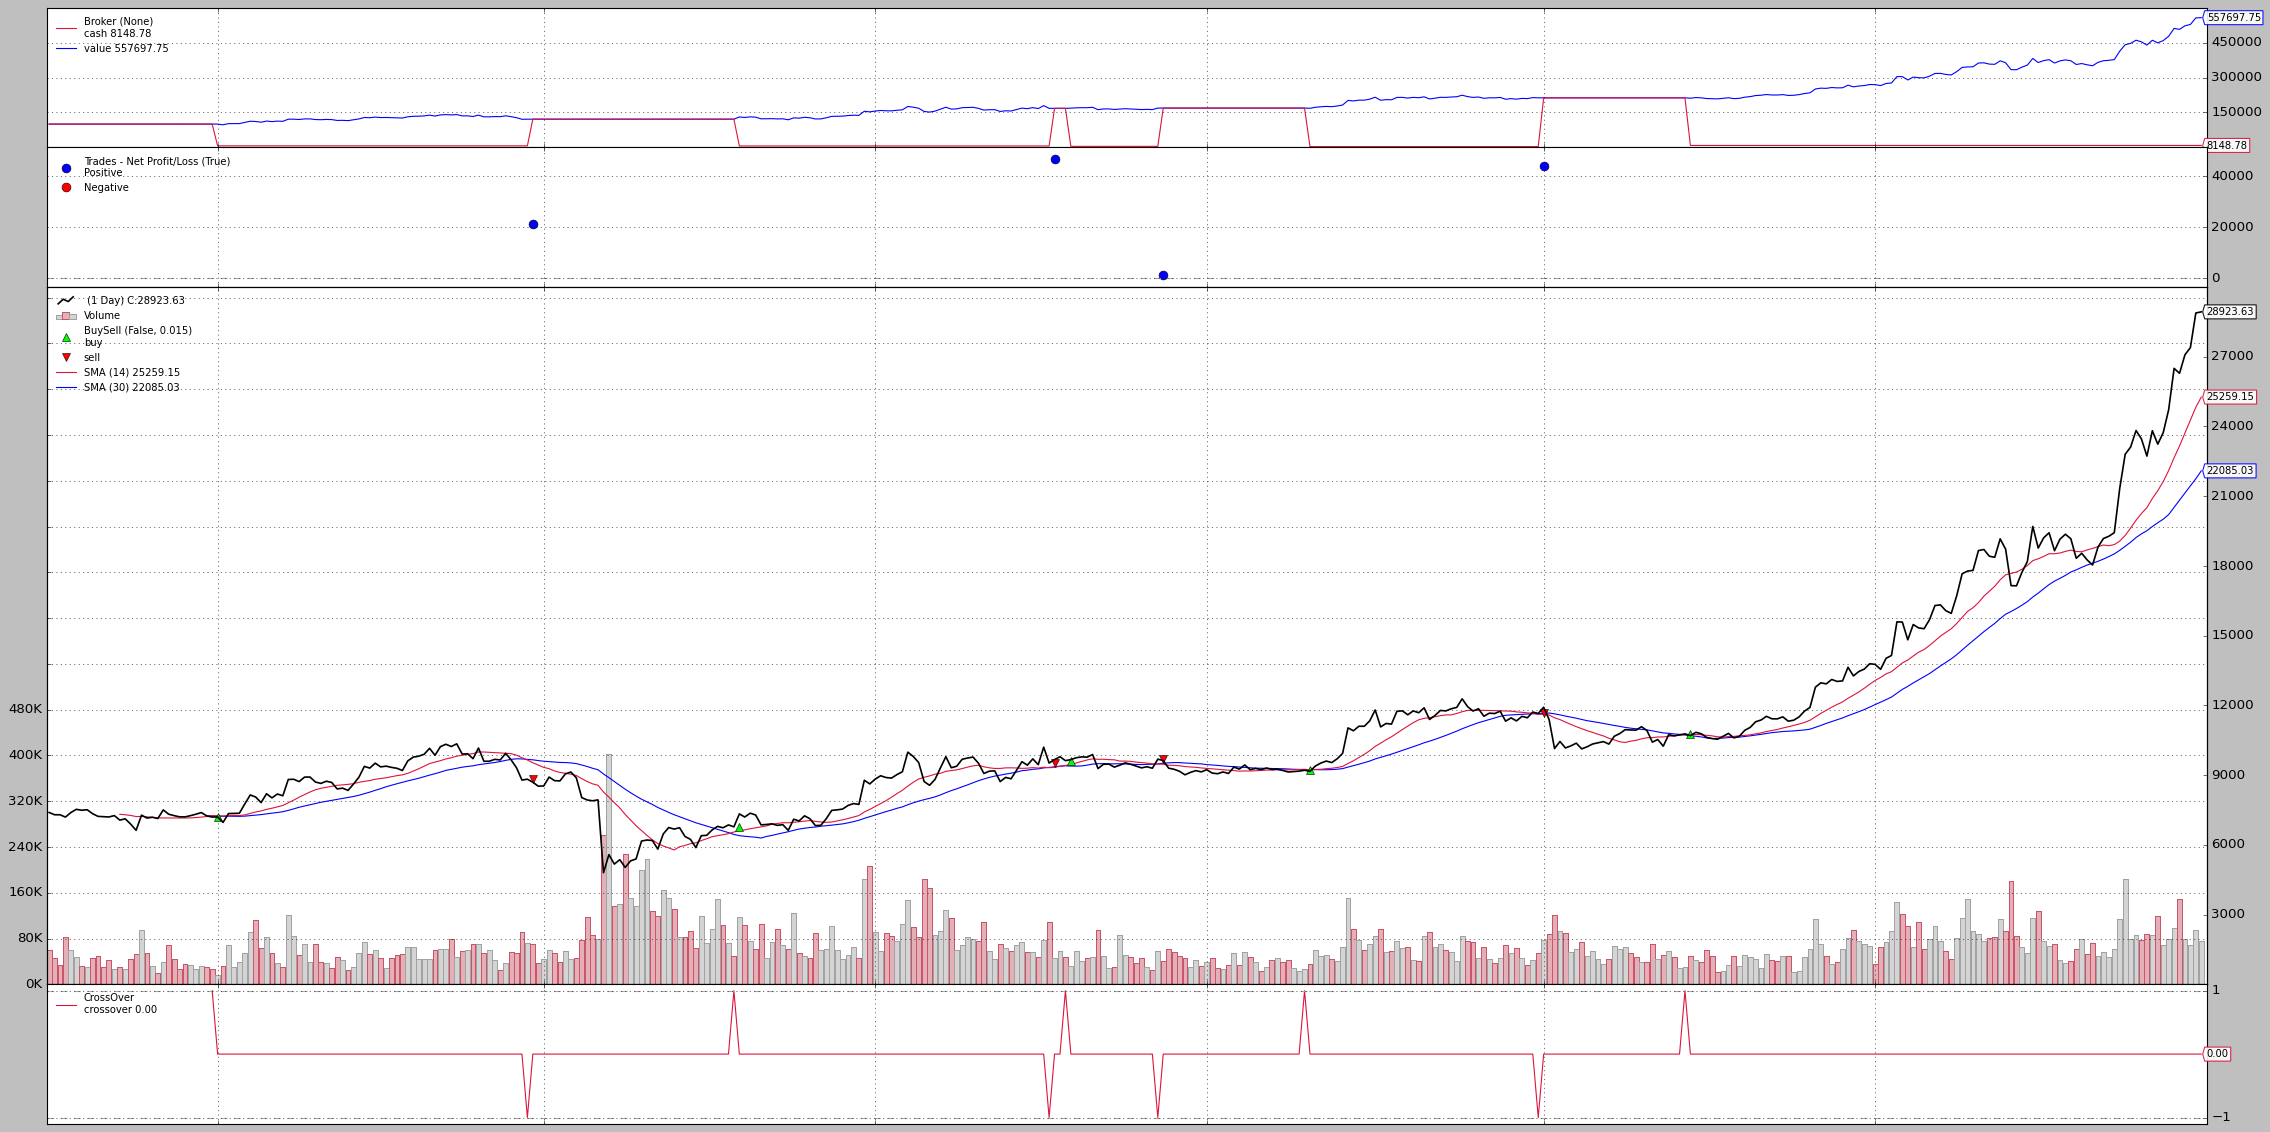

In [15]:
#mostra resultados com novos valores otimizados
results = backtest('smac', 
                   crypto, 
                   fast_period=fast_best, 
                   slow_period=slow_best,
                   plot=True,
                   verbose=False
                  )

## Acessando histórico de transações

Isso é feito definindo return_history = True.

### Estratégia Simples

In [16]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=fast_best, 
                               slow_period=slow_best,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [17]:
results

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,1.718647,0.004329,1.97704,197.704012,0,0.0,0.0,"{'len': 74, 'drawdown': 15.858760997423776, 'm...",15.858761,74,0.99563,457697.75,557697.75,5,0.8,4,0,28214.8825,28.214883,0.0,0.0,46669.42,46.66942,0.0,0.0


Com os Valores otimizados a performance é 457,70%.

In [18]:
history.keys()

dict_keys(['orders', 'periodic', 'indicators'])

In [19]:
orders = history['orders']
orders

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,fast_period14_slow_period30,2020-01-01,buy,7195.23,13,93537.99,0.0,0.00
1,0,fast_period14_slow_period30,2020-02-28,sell,8823.21,-13,93537.99,0.0,21163.74
2,0,fast_period14_slow_period30,2020-04-06,buy,6772.78,17,115137.26,0.0,0.00
3,0,fast_period14_slow_period30,2020-06-03,sell,9518.04,-17,115137.26,0.0,46669.42
4,0,fast_period14_slow_period30,2020-06-06,buy,9621.16,17,163559.72,0.0,0.00
5,0,fast_period14_slow_period30,2020-06-23,sell,9685.69,-17,163559.72,0.0,1097.01
6,0,fast_period14_slow_period30,2020-07-20,buy,9208.99,18,165761.82,0.0,0.00
7,0,fast_period14_slow_period30,2020-09-01,sell,11649.51,-18,165761.82,0.0,43929.36
8,0,fast_period14_slow_period30,2020-09-28,buy,10774.25,19,204710.75,0.0,0.00


O valor final dos resultados pode ser calculado a partir da comissão e pnl (lucro e perda = profit e loss) de todas as transações fechadas (compradas e vendidas) no histórico:



In [20]:
r = results.squeeze()
r.final_value

557697.75

In [21]:
r.init_cash + orders.pnl.sum() - orders.commission.sum()

212859.53000000003

### estratégia de sinal único com pesquisa de grade

In [22]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=[7,14,21], 
                               slow_period=[30,45,60],
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [24]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array(['fast_period7_slow_period30', 'fast_period7_slow_period45',
        'fast_period7_slow_period60', 'fast_period14_slow_period30',
        'fast_period14_slow_period45', 'fast_period14_slow_period60',
        'fast_period21_slow_period30', 'fast_period21_slow_period45',
        'fast_period21_slow_period60'], dtype=object))

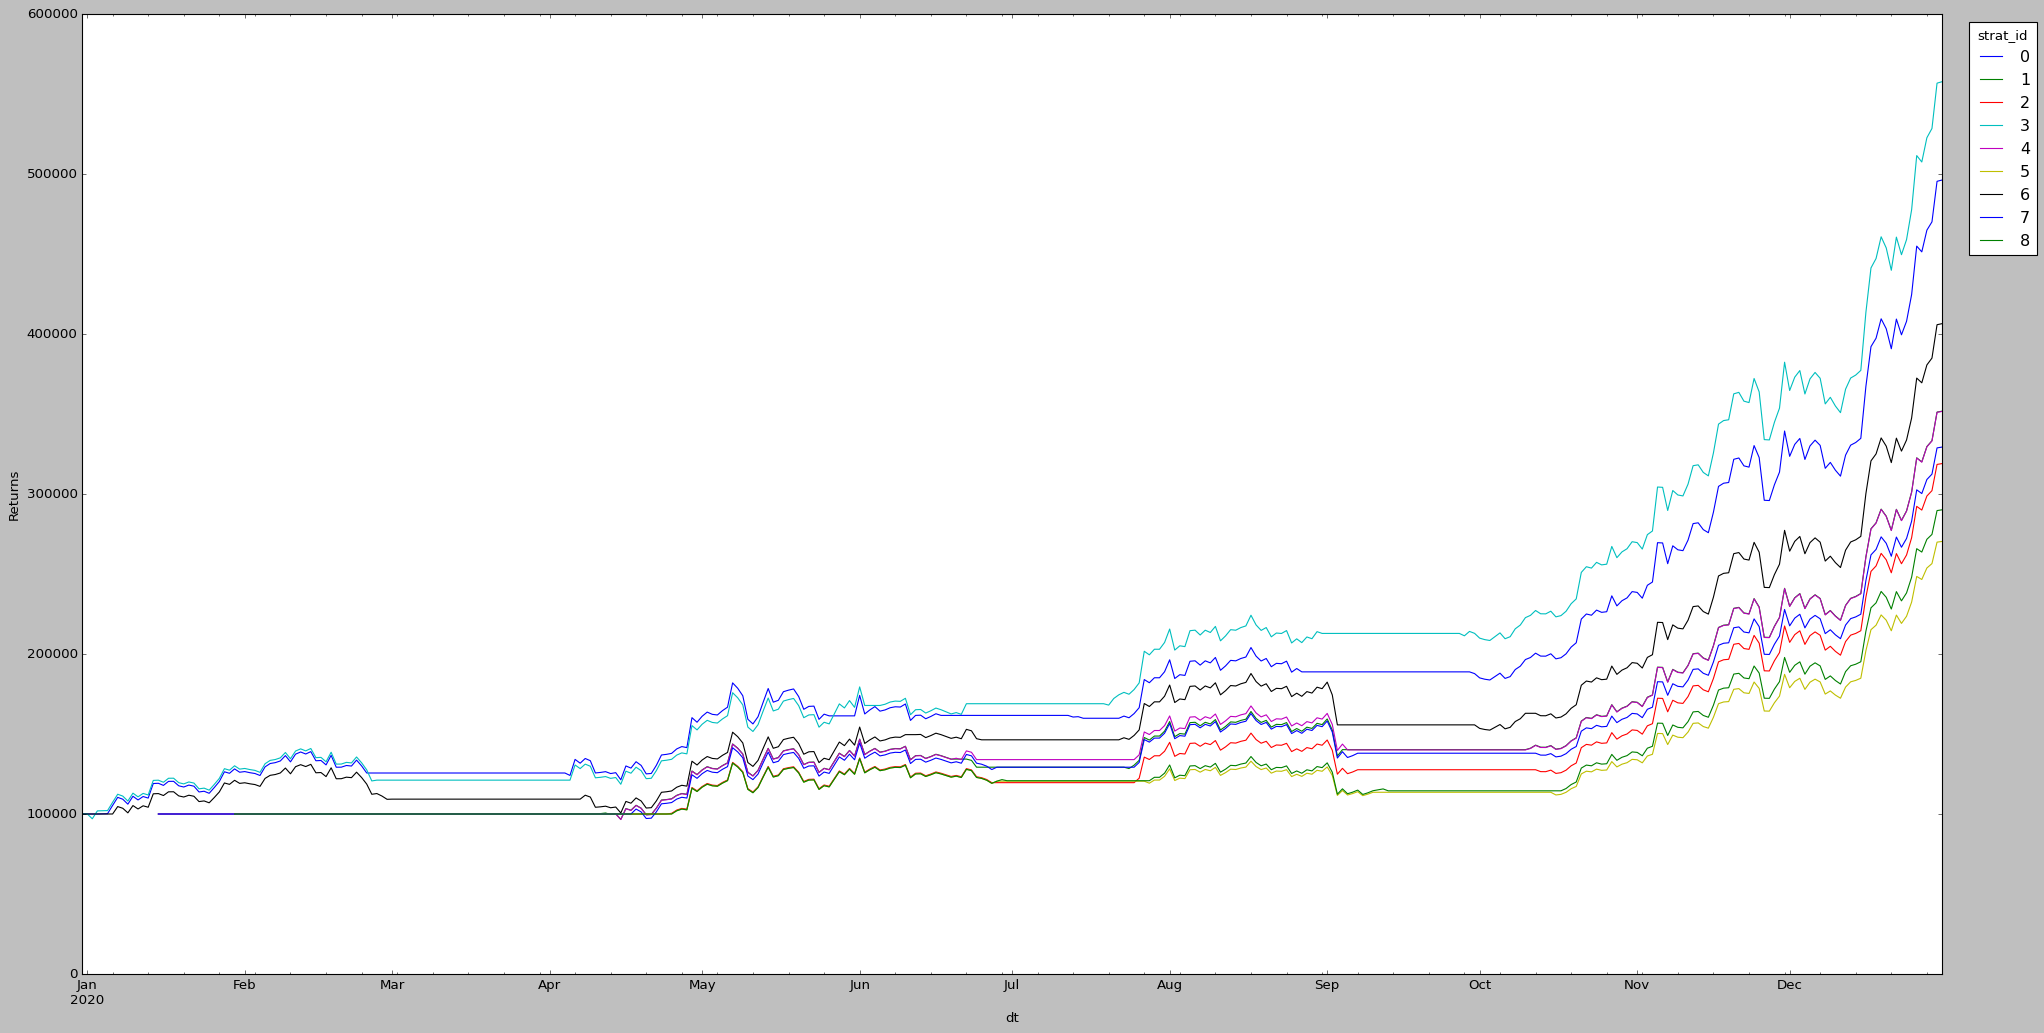

In [25]:
key = 'strat_id'
periodic = history['periodic']
g = periodic.set_index('dt').groupby(key)
axs = g.portfolio_value.plot(legend=key)
axs[0].set_ylabel('Returns')
axs[0].legend(g.groups, title=key, bbox_to_anchor=(1.01, 1), loc='upper left')

### estratégia multi sinal

In [27]:
# essa estratégia usa varios sinais(Cruzamento de média movel e RSI)
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': 7, 
           'slow_period': 60
            },
        'rsi': {
            'rsi_upper': 70,
            'rsi_lower': 30 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

2020-12-31T00:00:00, ===Global level arguments===
2020-12-31T00:00:00, init_cash : 100000
2020-12-31T00:00:00, buy_prop : 1
2020-12-31T00:00:00, sell_prop : 1
2020-12-31T00:00:00, commission : 0
2020-12-31T00:00:00, stop_loss : 0
2020-12-31T00:00:00, stop_trail : 0
2020-12-31T00:00:00, take_profit : 0
===Strategy level arguments===
fast_period : 7
slow_period : 60
2020-12-31T00:00:00, ===Global level arguments===
2020-12-31T00:00:00, init_cash : 100000
2020-12-31T00:00:00, buy_prop : 1
2020-12-31T00:00:00, sell_prop : 1
2020-12-31T00:00:00, commission : 0
2020-12-31T00:00:00, stop_loss : 0
2020-12-31T00:00:00, stop_trail : 0
2020-12-31T00:00:00, take_profit : 0
===Strategy level arguments===
rsi_period : 14
rsi_upper : 70
rsi_lower : 30
2019-12-17T00:00:00, BUY CREATE, 6623.82
2019-12-17T00:00:00, Cash: 100000.0
2019-12-17T00:00:00, Price: 6623.82
2019-12-17T00:00:00, Buy prop size: 15.08194665617422
2019-12-17T00:00:00, Afforded size: 15.08194665617422
2019-12-17T00:00:00, Final size:

In [28]:
results

,strat_id,init_cash,buy_prop,sell_prop,smac.fractional,smac.slippage,smac.single_position,smac.commission,smac.stop_loss,smac.stop_trail,smac.take_profit,execution_type,smac.channel,smac.symbol,smac.allow_short,smac.short_max,smac.add_cash_amount,smac.add_cash_freq,smac.invest_div,smac.fast_period,smac.slow_period,rsi.fractional,rsi.slippage,rsi.single_position,rsi.commission,rsi.stop_loss,rsi.stop_trail,rsi.take_profit,rsi.channel,rsi.symbol,rsi.allow_short,rsi.short_max,rsi.add_cash_amount,rsi.add_cash_freq,rsi.invest_div,rsi.rsi_period,rsi.rsi_upper,rsi.rsi_lower,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,30,1.101726,0.002775,1.012409,101.240855,0,0.0,0.0,"{'len': 14, 'drawdown': 12.579095262074336, 'm...",12.579095,14,1.089808,200935.53,300935.53,3,0.666667,2,0,70107.12,70.10712,0.0,0.0,107421.39,107.42139,0.0,0.0


usando estratégia multisinal a performance é 200,94%

In [29]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0]),
 array(['smac.fast_period7_slow_period60', 'rsi.rsi_upper70_rsi_lower30'],
       dtype=object))

In [30]:
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': [7,14], 
           'slow_period': [30,60]
            },
        'rsi': {
            'rsi_upper': [70,80],
            'rsi_lower': [20,30] 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

2020-12-31T00:00:00, ===Global level arguments===
2020-12-31T00:00:00, init_cash : 100000
2020-12-31T00:00:00, buy_prop : 1
2020-12-31T00:00:00, sell_prop : 1
2020-12-31T00:00:00, commission : 0
2020-12-31T00:00:00, stop_loss : 0
2020-12-31T00:00:00, stop_trail : 0
2020-12-31T00:00:00, take_profit : 0
===Strategy level arguments===
fast_period : 7
slow_period : 30
2020-12-31T00:00:00, ===Global level arguments===
2020-12-31T00:00:00, init_cash : 100000
2020-12-31T00:00:00, buy_prop : 1
2020-12-31T00:00:00, sell_prop : 1
2020-12-31T00:00:00, commission : 0
2020-12-31T00:00:00, stop_loss : 0
2020-12-31T00:00:00, stop_trail : 0
2020-12-31T00:00:00, take_profit : 0
===Strategy level arguments===
rsi_period : 14
rsi_upper : 70
rsi_lower : 20
2020-01-03T00:00:00, BUY CREATE, 7344.96
2020-01-03T00:00:00, Cash: 100000.0
2020-01-03T00:00:00, Price: 7344.96
2020-01-03T00:00:00, Buy prop size: 13.601176847811276
2020-01-03T00:00:00, Afforded size: 13.601176847811276
2020-01-03T00:00:00, Final siz

Com essa estratégia multisinal o ROI é  218,57%

In [31]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array(['smac.fast_period7_slow_period30', 'rsi.rsi_upper70_rsi_lower20',
        'rsi.rsi_upper70_rsi_lower30', 'rsi.rsi_upper80_rsi_lower20',
        'rsi.rsi_upper80_rsi_lower30', 'smac.fast_period7_slow_period60',
        'smac.fast_period14_slow_period30',
        'smac.fast_period14_slow_period60'], dtype=object))

### custom strategy

In [35]:
import numpy as np

#add a column which is a proxy buy/sell indicator for custom strategy
crypto["custom"] = crypto.close.pct_change()

In [36]:
results, history = backtest('custom', 
                                crypto, 
                                upper_limit=0.05, 
                                lower_limit=-0.05,
                                plot=False,
                                verbose=False,
                                return_history=True
                                )

===Strategy level arguments===
Upper limit:  0.05
Lower limit:  -0.05


In [37]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0]), array(['upper_limit0.05_lower_limit-0.05'], dtype=object))